# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [9]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Create training set and define training dataloader
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

MNIST digits are already clean, consistent, and standardized at 28×28 pixels. Keeping preprocessing simple allows us to focus on the model training itself. For this project, I chose two simple preprocessing steps to the MNIST dataset:

1. **`ToTensor()`**  
   - Converts images into PyTorch tensors (required for model training).  
   - Also scales pixel values from `[0, 255]` to `[0, 1]`.  

2. **`Normalize((0.5,), (0.5,))`**  
   - Shifts the pixel range to be centered around `0` (from `-1` to `1`).  
   - This makes training more stable and helps the model converge faster.  


**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Number of training samples: 60000
Number of test samples: 10000
Single image shape: torch.Size([1, 28, 28])
Label: 5
0


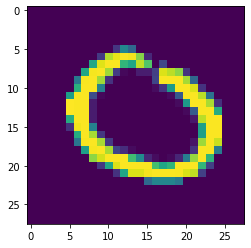

7


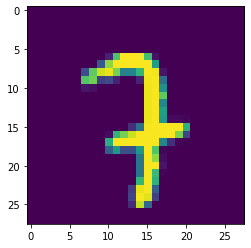

1


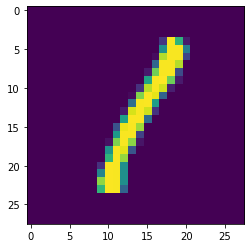

0


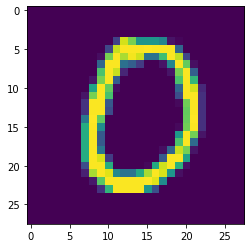

0


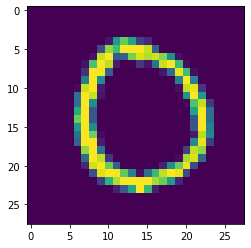

In [6]:
# Explore data

# Looks at the size/shape of the training set
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

# Checks one image and its label
image, label = train_dataset[0]
print("Single image shape:", image.shape)
print("Label:", label)

# Shows 5 sample images from the training data
show5(train_loader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
# Define the neural network
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()                      
        self.fc1 = nn.Linear(28*28, 128)                 # first hidden layer
        self.fc2 = nn.Linear(128, 64)                    # second hidden layer
        self.fc3 = nn.Linear(64, 10)                     # output layer (10 digits)
    
    def forward(self, x):
        x = self.flatten(x)                              # flatten the image
        x = F.relu(self.fc1(x))                          # hidden layer 1 + ReLU
        x = F.relu(self.fc2(x))                          # hidden layer 2 + ReLU
        x = self.fc3(x)                                  # output layer (logits)
        return x

# Create the model instance
model = MNISTClassifier()
print(model)


MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
#Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
# Adam is chosen because it adapts the learning rate during training and usually converges faster than SGD.
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model.to(device)

# Training
epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()  # training mode
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print progress every 250 batches
        if (batch_idx+1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Avg Training Loss: {epoch_loss:.4f}")

Using device: cuda
Epoch [1/5], Step [250/938], Loss: 0.3646
Epoch [1/5], Step [500/938], Loss: 0.2227
Epoch [1/5], Step [750/938], Loss: 0.4702
Epoch [1/5], Avg Training Loss: 0.4075
Epoch [2/5], Step [250/938], Loss: 0.2416
Epoch [2/5], Step [500/938], Loss: 0.1556
Epoch [2/5], Step [750/938], Loss: 0.1259
Epoch [2/5], Avg Training Loss: 0.1939
Epoch [3/5], Step [250/938], Loss: 0.1009
Epoch [3/5], Step [500/938], Loss: 0.1156
Epoch [3/5], Step [750/938], Loss: 0.0937
Epoch [3/5], Avg Training Loss: 0.1366
Epoch [4/5], Step [250/938], Loss: 0.1564
Epoch [4/5], Step [500/938], Loss: 0.1085
Epoch [4/5], Step [750/938], Loss: 0.1175
Epoch [4/5], Avg Training Loss: 0.1089
Epoch [5/5], Step [250/938], Loss: 0.0480
Epoch [5/5], Step [500/938], Loss: 0.1550
Epoch [5/5], Step [750/938], Loss: 0.0144
Epoch [5/5], Avg Training Loss: 0.0955


Plot the training loss (and validation loss/accuracy, if recorded).

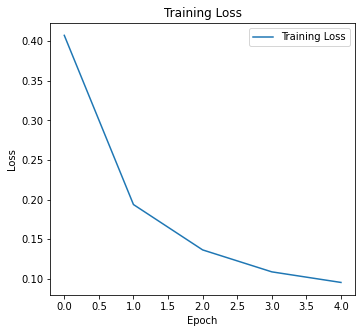

In [12]:
# Plot Training Loss & Test Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
# Put model in evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class (highest probability)
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.73%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
from torch.optim.lr_scheduler import StepLR

# Optimizer + Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # reduce lr by 0.1 every 3 epochs

epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print progress every 250 batches
        if (batch_idx+1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # ---- Testing ----
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # Step the scheduler (update learning rate)
    scheduler.step()

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_loss:.4f} | Test Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()}")


Epoch [1/5], Step [250/938], Loss: 0.0587
Epoch [1/5], Step [500/938], Loss: 0.2885
Epoch [1/5], Step [750/938], Loss: 0.0461
Epoch [1/5] | Train Loss: 0.0823 | Test Accuracy: 96.64% | LR: [0.001]
Epoch [2/5], Step [250/938], Loss: 0.0693
Epoch [2/5], Step [500/938], Loss: 0.0821
Epoch [2/5], Step [750/938], Loss: 0.0034
Epoch [2/5] | Train Loss: 0.0719 | Test Accuracy: 97.08% | LR: [0.001]
Epoch [3/5], Step [250/938], Loss: 0.1091
Epoch [3/5], Step [500/938], Loss: 0.0374
Epoch [3/5], Step [750/938], Loss: 0.0590
Epoch [3/5] | Train Loss: 0.0662 | Test Accuracy: 96.76% | LR: [0.0001]
Epoch [4/5], Step [250/938], Loss: 0.0565
Epoch [4/5], Step [500/938], Loss: 0.0111
Epoch [4/5], Step [750/938], Loss: 0.0746
Epoch [4/5] | Train Loss: 0.0332 | Test Accuracy: 97.85% | LR: [0.0001]
Epoch [5/5], Step [250/938], Loss: 0.0091
Epoch [5/5], Step [500/938], Loss: 0.0049
Epoch [5/5], Step [750/938], Loss: 0.0128
Epoch [5/5] | Train Loss: 0.0285 | Test Accuracy: 97.91% | LR: [0.0001]


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
# Save the entire model
torch.save(model.state_dict(), "mnist_cnn.pth")
print("Model saved as mnist_cnn.pth")

Model saved as mnist_cnn.pth


In [ ]:
# Initialize model again (same architecture!)
# model = CNN().to(device)

# Load weights
# model.load_state_dict(torch.load("mnist_cnn.pth"))
# model.eval()
